## POS tagging using modified Viterbi

### Data Preparation

In [48]:
#Importing libraries
import nltk, re, pprint
nltk.download('universal_tagset')
nltk.download('punkt')
import numpy as np
import pandas as pd
import requests
import matplotlib.pyplot as plt
import seaborn as sns
import pprint, time
import random
from sklearn.model_selection import train_test_split
from nltk.tokenize import word_tokenize

[nltk_data] Downloading package universal_tagset to
[nltk_data]     C:\Users\DELL\AppData\Roaming\nltk_data...
[nltk_data]   Package universal_tagset is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\DELL\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping tokenizers\punkt.zip.


[nltk_data] Downloading package treebank to
[nltk_data]     C:\Users\DELL\AppData\Roaming\nltk_data...
[nltk_data]   Package treebank is already up-to-date!


In [10]:
# first few tagged sentences
print(wsj[:5])

[[('Pierre', 'NNP'), ('Vinken', 'NNP'), (',', ','), ('61', 'CD'), ('years', 'NNS'), ('old', 'JJ'), (',', ','), ('will', 'MD'), ('join', 'VB'), ('the', 'DT'), ('board', 'NN'), ('as', 'IN'), ('a', 'DT'), ('nonexecutive', 'JJ'), ('director', 'NN'), ('Nov.', 'NNP'), ('29', 'CD'), ('.', '.')], [('Mr.', 'NNP'), ('Vinken', 'NNP'), ('is', 'VBZ'), ('chairman', 'NN'), ('of', 'IN'), ('Elsevier', 'NNP'), ('N.V.', 'NNP'), (',', ','), ('the', 'DT'), ('Dutch', 'NNP'), ('publishing', 'VBG'), ('group', 'NN'), ('.', '.')], [('Rudolph', 'NNP'), ('Agnew', 'NNP'), (',', ','), ('55', 'CD'), ('years', 'NNS'), ('old', 'JJ'), ('and', 'CC'), ('former', 'JJ'), ('chairman', 'NN'), ('of', 'IN'), ('Consolidated', 'NNP'), ('Gold', 'NNP'), ('Fields', 'NNP'), ('PLC', 'NNP'), (',', ','), ('was', 'VBD'), ('named', 'VBN'), ('*-1', '-NONE-'), ('a', 'DT'), ('nonexecutive', 'JJ'), ('director', 'NN'), ('of', 'IN'), ('this', 'DT'), ('British', 'JJ'), ('industrial', 'JJ'), ('conglomerate', 'NN'), ('.', '.')], [('A', 'DT'), ('f

In [11]:
# Splitting into train and test
random.seed(1234)
train_set, test_set = train_test_split(wsj,test_size=0.3)

print(len(train_set))
print(len(test_set))
print(train_set[:5])

2739
1175
[[('Such', 'JJ'), ('laws', 'NNS'), ('violate', 'VBP'), ('the', 'DT'), ('provision', 'NN'), ('in', 'IN'), ('Article', 'NNP'), ('II', 'NNP'), ('that', 'WDT'), ('*T*-1', '-NONE-'), ('requires', 'VBZ'), ('the', 'DT'), ('president', 'NN'), ('to', 'TO'), ('make', 'VB'), ('recommendations', 'NNS'), ('to', 'TO'), ('Congress', 'NNP'), (',', ','), ('but', 'CC'), ('which', 'WDT'), ('*T*-41', '-NONE-'), ('gives', 'VBZ'), ('the', 'DT'), ('president', 'NN'), ('the', 'DT'), ('discretion', 'NN'), ('0', '-NONE-'), ('*', '-NONE-'), ('to', 'TO'), ('select', 'VB'), ('the', 'DT'), ('subject', 'JJ'), ('matter', 'NN'), ('of', 'IN'), ('those', 'DT'), ('recommendations', 'NNS'), ('*T*-2', '-NONE-'), ('.', '.')], [('South', 'NNP'), ('African', 'NNP'), ('troops', 'NNS'), ('were', 'VBD'), ('placed', 'VBN'), ('*-1', '-NONE-'), ('on', 'IN'), ('alert', 'NN'), ('.', '.')], [('Last', 'JJ'), ('month', 'NN'), (',', ','), ('Judge', 'NNP'), ('Curry', 'NNP'), ('set', 'VBD'), ('the', 'DT'), ('interest', 'NN'), ('r

In [12]:
# Getting list of tagged words
train_tagged_words = [tup for sent in train_set for tup in sent]
len(train_tagged_words)

70691

In [13]:
# tokens 
tokens = [pair[0] for pair in train_tagged_words]
tokens[:10]

['Such',
 'laws',
 'violate',
 'the',
 'provision',
 'in',
 'Article',
 'II',
 'that',
 '*T*-1']

In [19]:
# reading the Treebank tagged sentences
nltk_data = list(nltk.corpus.treebank.tagged_sents(tagset='universal'))

In [20]:
# first few tagged sentences
print(nltk_data[:10])

[[('Pierre', 'NOUN'), ('Vinken', 'NOUN'), (',', '.'), ('61', 'NUM'), ('years', 'NOUN'), ('old', 'ADJ'), (',', '.'), ('will', 'VERB'), ('join', 'VERB'), ('the', 'DET'), ('board', 'NOUN'), ('as', 'ADP'), ('a', 'DET'), ('nonexecutive', 'ADJ'), ('director', 'NOUN'), ('Nov.', 'NOUN'), ('29', 'NUM'), ('.', '.')], [('Mr.', 'NOUN'), ('Vinken', 'NOUN'), ('is', 'VERB'), ('chairman', 'NOUN'), ('of', 'ADP'), ('Elsevier', 'NOUN'), ('N.V.', 'NOUN'), (',', '.'), ('the', 'DET'), ('Dutch', 'NOUN'), ('publishing', 'VERB'), ('group', 'NOUN'), ('.', '.')], [('Rudolph', 'NOUN'), ('Agnew', 'NOUN'), (',', '.'), ('55', 'NUM'), ('years', 'NOUN'), ('old', 'ADJ'), ('and', 'CONJ'), ('former', 'ADJ'), ('chairman', 'NOUN'), ('of', 'ADP'), ('Consolidated', 'NOUN'), ('Gold', 'NOUN'), ('Fields', 'NOUN'), ('PLC', 'NOUN'), (',', '.'), ('was', 'VERB'), ('named', 'VERB'), ('*-1', 'X'), ('a', 'DET'), ('nonexecutive', 'ADJ'), ('director', 'NOUN'), ('of', 'ADP'), ('this', 'DET'), ('British', 'ADJ'), ('industrial', 'ADJ'), ('

In [21]:

# Splitting into train and test
random.seed(1234)
train_set, test_set = train_test_split(nltk_data,test_size=0.05)

print(len(train_set))
print(len(test_set))
print(train_set[:5])

3718
196
[[('But', 'CONJ'), ('the', 'DET'), ('1989', 'NUM'), ('fall', 'NOUN'), ('total', 'NOUN'), ('of', 'ADP'), ('80', 'NUM'), (',', '.'), ('while', 'ADP'), ('well', 'ADV'), ('below', 'ADP'), ('1988', 'NUM'), ('activity', 'NOUN'), (',', '.'), ('shows', 'VERB'), ('``', '.'), ('a', 'DET'), ('steady', 'ADJ'), ('ratcheting', 'VERB'), ('up', 'ADP'), ('in', 'ADP'), ('citizen', 'NOUN'), ('referenda', 'NOUN'), ('and', 'CONJ'), ('initiatives', 'VERB'), (',', '.'), ("''", '.'), ('says', 'VERB'), ('0', 'X'), ('*T*-1', 'X'), ('Patrick', 'NOUN'), ('McGuigan', 'NOUN'), (',', '.'), ('editor', 'NOUN'), ('of', 'ADP'), ('Family', 'NOUN'), (',', '.'), ('Law', 'NOUN'), ('and', 'CONJ'), ('Democracy', 'NOUN'), ('Report', 'NOUN'), ('.', '.')], [('*-2', 'X'), ('Given', 'VERB'), ('*-3', 'X'), ('that', 'DET'), ('choice', 'NOUN'), (',', '.'), ('associates', 'NOUN'), ('of', 'ADP'), ('Mr.', 'NOUN'), ('Hahn', 'NOUN'), ('and', 'CONJ'), ('industry', 'NOUN'), ('observers', 'NOUN'), ('say', 'VERB'), ('0', 'X'), ('the'

In [22]:
# Getting list of tagged words
train_tagged_words = [tup for sent in train_set for tup in sent]
len(train_tagged_words)

95672

In [23]:

# tokens 
tokens = [pair[0] for pair in train_tagged_words]
tokens[:10]

['But', 'the', '1989', 'fall', 'total', 'of', '80', ',', 'while', 'well']

In [24]:
# vocabulary
V = set(tokens)
print(len(V))

12079


In [27]:
# number of tags
T = set([pair[1] for pair in train_tagged_words])
len(T)

12

In [28]:
print(T)

{'ADJ', 'X', 'ADP', 'PRON', 'DET', 'CONJ', '.', 'ADV', 'NOUN', 'VERB', 'PRT', 'NUM'}


# POS Tagging Algorithm - HMM

# #Emission Probabilities

In [29]:
# computing P(w/t) and storing in T x V matrix
t = len(T)
v = len(V)
w_given_t = np.zeros((t, v))

In [30]:
# compute word given tag: Emission Probability
def word_given_tag(word, tag, train_bag = train_tagged_words):
    tag_list = [pair for pair in train_bag if pair[1]==tag]
    count_tag = len(tag_list)
    w_given_tag_list = [pair[0] for pair in tag_list if pair[0]==word]
    count_w_given_tag = len(w_given_tag_list)
    
    return (count_w_given_tag, count_tag)

Transition Probabilities

In [32]:
# compute tag given tag: tag2(t2) given tag1 (t1), i.e. Transition Probability

def t2_given_t1(t2, t1, train_bag = train_tagged_words):
    tags = [pair[1] for pair in train_bag]
    count_t1 = len([t for t in tags if t==t1])
    count_t2_t1 = 0
    for index in range(len(tags)-1):
        if tags[index]==t1 and tags[index+1] == t2:
            count_t2_t1 += 1
    return (count_t2_t1, count_t1)

In [33]:
# creating t x t transition matrix of tags
# each column is t2, each row is t1
# thus M(i, j) represents P(tj given ti)

tags_matrix = np.zeros((len(T), len(T)), dtype='float32')
for i, t1 in enumerate(list(T)):
    for j, t2 in enumerate(list(T)): 
        tags_matrix[i, j] = t2_given_t1(t2, t1)[0]/t2_given_t1(t2, t1)[1]

In [34]:
tags_matrix

array([[6.60952702e-02, 2.14273948e-02, 7.68089667e-02, 6.59304438e-04,
        5.10960957e-03, 1.71419159e-02, 6.39525279e-02, 4.45030490e-03,
        7.00675786e-01, 1.23619577e-02, 1.08785229e-02, 2.04384383e-02],
       [1.71265453e-02, 7.56422430e-02, 1.42404065e-01, 5.59784323e-02,
        5.48683777e-02, 1.01490645e-02, 1.65080875e-01, 2.48969235e-02,
        6.21630177e-02, 2.03932762e-01, 1.85220420e-01, 2.53726612e-03],
       [1.06867783e-01, 3.43388952e-02, 1.73299108e-02, 6.87847659e-02,
        3.24026525e-01, 9.62772814e-04, 3.99015844e-02, 1.35857938e-02,
        3.22100997e-01, 7.91613199e-03, 1.49764656e-03, 6.26872033e-02],
       [7.27202743e-02, 9.31127369e-02, 2.30858028e-02, 8.08003079e-03,
        9.23432130e-03, 4.23239730e-03, 4.11696807e-02, 3.34744118e-02,
        2.07772225e-01, 4.86340910e-01, 1.30819548e-02, 7.69526744e-03],
       [2.04180256e-01, 4.53062691e-02, 9.30288713e-03, 3.50368489e-03,
        5.67838596e-03, 3.62450170e-04, 1.77600589e-02, 1.26

In [35]:
# convert the matrix to a df for better readability
tags_df = pd.DataFrame(tags_matrix, columns = list(T), index=list(T))

In [36]:
tags_df

,ADJ,X,ADP,PRON,DET,CONJ,.,ADV,NOUN,VERB,PRT,NUM
ADJ,0.066095,0.021427,0.076809,0.000659,0.005110,0.017142,0.063953,0.004450,0.700676,0.012362,0.010879,0.020438
X,0.017127,0.075642,0.142404,0.055978,0.054868,0.010149,0.165081,0.024897,0.062163,0.203933,0.185220,0.002537
ADP,0.106868,0.034339,0.017330,0.068785,0.324027,0.000963,0.039902,0.013586,0.322101,0.007916,0.001498,0.062687
PRON,0.072720,0.093113,0.023086,0.008080,0.009234,0.004232,0.041170,0.033474,0.207772,0.486341,0.013082,0.007695
DET,0.204180,0.045306,0.009303,0.003504,0.005678,0.000362,0.017760,0.012686,0.639362,0.039749,0.000242,0.021868
CONJ,0.118004,0.008862,0.051306,0.060634,0.117537,0.000466,0.035914,0.054104,0.349813,0.157183,0.004664,0.041511
.,0.043849,0.027170,0.089939,0.066356,0.172525,0.057658,0.094781,0.052726,0.222920,0.088773,0.002331,0.080882
ADV,0.131509,0.023031,0.119493,0.015020,0.069426,0.006342,0.136849,0.077103,0.032710,0.343458,0.014019,0.031041
NOUN,0.011880,0.029299,0.177180,0.004409,0.013265,0.042528,0.239569,0.016909,0.263875,0.147225,0.044350,0.009511
VERB,0.065478,0.218287,0.090508,0.035103,0.134444,0.005502,0.035413,0.081596,0.110965,0.168927,0.031228,0.022549


In [37]:
tags_df.loc['.', :]

ADJ     0.043849
X       0.027170
ADP     0.089939
PRON    0.066356
DET     0.172525
CONJ    0.057658
.       0.094781
ADV     0.052726
NOUN    0.222920
VERB    0.088773
PRT     0.002331
NUM     0.080882
Name: ., dtype: float32

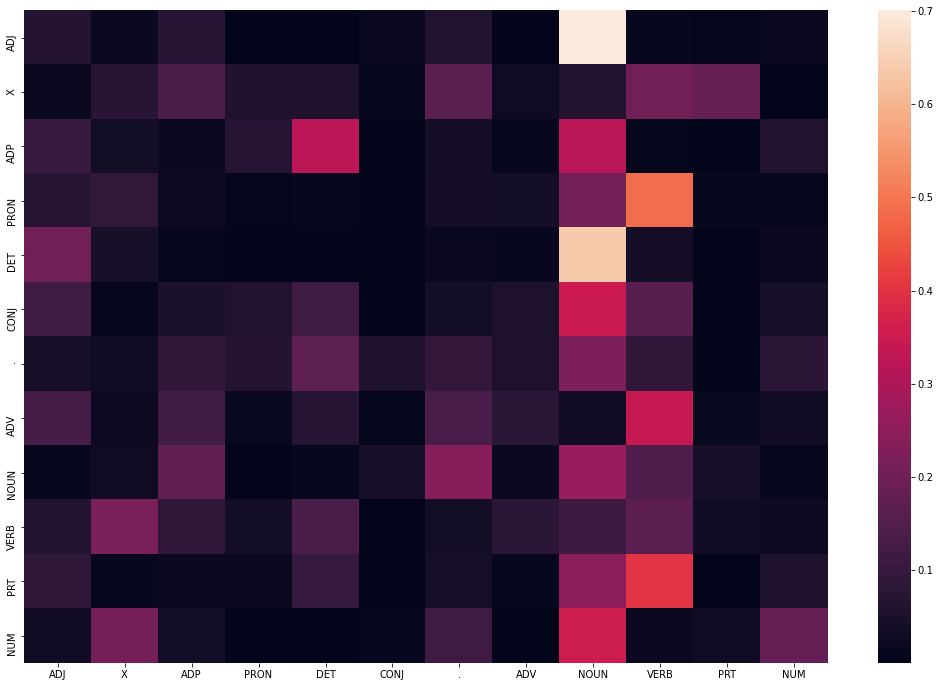

In [38]:
# heatmap of tags matrix
# T(i, j) means P(tag j given tag i)
plt.figure(figsize=(18, 12))
sns.heatmap(tags_df)
plt.show()

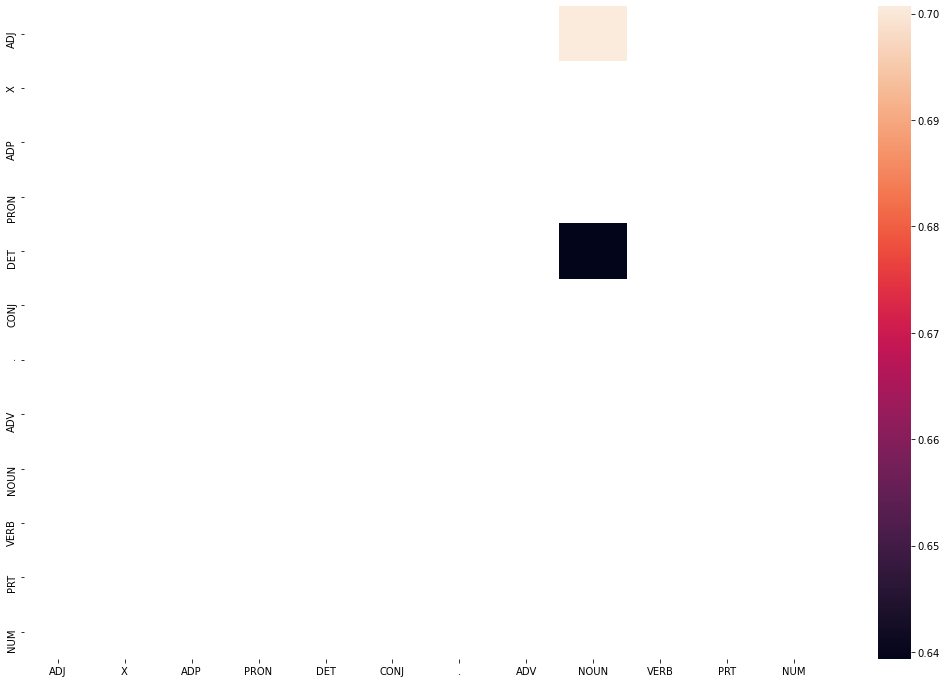

In [39]:
# frequent tags
# filter the df to get P(t2, t1) > 0.5
tags_frequent = tags_df[tags_df>0.5]
plt.figure(figsize=(18, 12))
sns.heatmap(tags_frequent)
plt.show()

In [40]:

len(train_tagged_words)

95672

### Build the vanilla Viterbi based POS tagger

In [41]:
# Viterbi Heuristic
def Viterbi(words, train_bag = train_tagged_words):
    state = []
    T = list(set([pair[1] for pair in train_bag]))
    
    for key, word in enumerate(words):
        #initialise list of probability column for a given observation
        p = [] 
        for tag in T:
            if key == 0:
                transition_p = tags_df.loc['.', tag]
            else:
                transition_p = tags_df.loc[state[-1], tag]
                
            # compute emission and state probabilities
            emission_p = word_given_tag(words[key], tag)[0]/word_given_tag(words[key], tag)[1]
            state_probability = emission_p * transition_p    
            p.append(state_probability)
            
        pmax = max(p)
        # getting state for which probability is maximum
        state_max = T[p.index(pmax)] 
        state.append(state_max)
    return list(zip(words, state))

In [42]:
# Running on entire test dataset would take more than 3-4hrs. 
# Let's test our Viterbi algorithm on a few sample sentences of test dataset

random.seed(1234)

# choose random 5 sents
rndom = [random.randint(1,len(test_set)) for x in range(5)]

# list of sents
test_run = [test_set[i] for i in rndom]

# list of tagged words
test_run_base = [tup for sent in test_run for tup in sent]

# list of untagged words
test_tagged_words = [tup[0] for sent in test_run for tup in sent]
test_run

[[('As', 'ADP'),
  ('a', 'DET'),
  ('part', 'NOUN'),
  ('of', 'ADP'),
  ('overall', 'ADJ'),
  ('efforts', 'NOUN'),
  ('*', 'X'),
  ('to', 'PRT'),
  ('reduce', 'VERB'),
  ('spending', 'NOUN'),
  (',', '.'),
  ('Congress', 'NOUN'),
  ('cut', 'VERB'),
  ('by', 'ADP'),
  ('$', '.'),
  ('30', 'NUM'),
  ('million', 'NUM'),
  ('*U*', 'X'),
  ('the', 'DET'),
  ('Bush', 'NOUN'),
  ('administration', 'NOUN'),
  ("'s", 'PRT'),
  ('request', 'NOUN'),
  ('for', 'ADP'),
  ('antitrust', 'ADJ'),
  ('enforcement', 'NOUN'),
  ('for', 'ADP'),
  ('fiscal', 'ADJ'),
  ('1990', 'NUM'),
  (',', '.'),
  ('which', 'DET'),
  ('*T*-81', 'X'),
  ('began', 'VERB'),
  ('Oct.', 'NOUN'),
  ('1', 'NUM'),
  ('.', '.')],
 [('Meanwhile', 'ADV'),
  (',', '.'),
  ('the', 'DET'),
  ('National', 'NOUN'),
  ('Association', 'NOUN'),
  ('of', 'ADP'),
  ('Purchasing', 'NOUN'),
  ('Management', 'NOUN'),
  ('said', 'VERB'),
  ('0', 'X'),
  ('its', 'PRON'),
  ('latest', 'ADJ'),
  ('survey', 'NOUN'),
  ('indicated', 'VERB'),
  ('that

In [43]:

# tagging the test sentences
start = time.time()
tagged_seq = Viterbi(test_tagged_words)
end = time.time()
difference = end-start

In [44]:
print("Time taken in seconds: ", difference)
print(tagged_seq)
#print(test_run_base)

Time taken in seconds:  31.537096977233887
[('As', 'ADP'), ('a', 'DET'), ('part', 'NOUN'), ('of', 'ADP'), ('overall', 'ADJ'), ('efforts', 'NOUN'), ('*', 'X'), ('to', 'PRT'), ('reduce', 'VERB'), ('spending', 'NOUN'), (',', '.'), ('Congress', 'NOUN'), ('cut', 'VERB'), ('by', 'ADP'), ('$', '.'), ('30', 'NUM'), ('million', 'NUM'), ('*U*', 'X'), ('the', 'DET'), ('Bush', 'NOUN'), ('administration', 'NOUN'), ("'s", 'PRT'), ('request', 'NOUN'), ('for', 'ADP'), ('antitrust', 'ADJ'), ('enforcement', 'NOUN'), ('for', 'ADP'), ('fiscal', 'ADJ'), ('1990', 'NUM'), (',', '.'), ('which', 'DET'), ('*T*-81', 'ADJ'), ('began', 'VERB'), ('Oct.', 'NOUN'), ('1', 'NUM'), ('.', '.'), ('Meanwhile', 'ADV'), (',', '.'), ('the', 'DET'), ('National', 'NOUN'), ('Association', 'NOUN'), ('of', 'ADP'), ('Purchasing', 'NOUN'), ('Management', 'NOUN'), ('said', 'VERB'), ('0', 'X'), ('its', 'PRON'), ('latest', 'ADJ'), ('survey', 'NOUN'), ('indicated', 'VERB'), ('that', 'ADP'), ('the', 'DET'), ('manufacturing', 'NOUN'), ('e

In [45]:

# accuracy
check = [i for i, j in zip(tagged_seq, test_run_base) if i == j]
accuracy_vanilla_viterbi = len(check)/len(tagged_seq)
accuracy_vanilla_viterbi

0.9101123595505618

In [46]:
incorrect_tagged_vanilla_viterbi = [[test_run_base[i-1],j] for i, j in enumerate(zip(tagged_seq, test_run_base)) if j[0]!=j[1]]
incorrect_tagged_vanilla_viterbi

[[('which', 'DET'), (('*T*-81', 'ADJ'), ('*T*-81', 'X'))],
 [('*', 'X'), (('upsetting', 'ADJ'), ('upsetting', 'VERB'))],
 [('its', 'PRON'), (('Caribbean', 'ADJ'), ('Caribbean', 'NOUN'))],
 [('Caribbean', 'NOUN'), (('Basin', 'ADJ'), ('Basin', 'NOUN'))],
 [('Basin', 'NOUN'), (('allies', 'ADJ'), ('allies', 'NOUN'))],
 [('apparently', 'ADV'), (('instructed', 'ADJ'), ('instructed', 'VERB'))],
 [('its', 'PRON'), (('lobbyist', 'ADJ'), ('lobbyist', 'NOUN'))],
 [('initially', 'ADV'), (('drafted', 'ADJ'), ('drafted', 'VERB'))],
 [('Mr.', 'NOUN'), (('Inouye', 'ADJ'), ('Inouye', 'NOUN'))],
 [('to', 'PRT'), (('insert', 'ADJ'), ('insert', 'VERB'))],
 [('$', '.'), (('9.3', 'ADJ'), ('9.3', 'NUM'))],
 [('House', 'NOUN'), (('Majority', 'ADJ'), ('Majority', 'NOUN'))],
 [('Majority', 'NOUN'), (('Whip', 'ADJ'), ('Whip', 'NOUN'))],
 [(',', '.'), (('Pa', 'ADJ'), ('Pa', 'NOUN'))],
 [('the', 'DET'), (('Caribbean', 'ADJ'), ('Caribbean', 'NOUN'))],
 [('and', 'CONJ'), (('Barbados', 'ADJ'), ('Barbados', 'NOUN'))]]

In [49]:
## Testing
sentence_test = 'Google and Twitter made a deal in 2015 that gave Google access to Twitter\'s firehose.'
words = word_tokenize(sentence_test)

start = time.time()
tagged_seq = Viterbi(words)
end = time.time()
difference = end-start

In [50]:
print(tagged_seq)
print(difference)

[('Google', 'ADJ'), ('and', 'CONJ'), ('Twitter', 'ADJ'), ('made', 'VERB'), ('a', 'DET'), ('deal', 'NOUN'), ('in', 'ADP'), ('2015', 'ADJ'), ('that', 'ADP'), ('gave', 'VERB'), ('Google', 'ADJ'), ('access', 'NOUN'), ('to', 'PRT'), ('Twitter', 'ADJ'), ("'s", 'PRT'), ('firehose', 'ADJ'), ('.', '.')]
2.9389004707336426


### Solve the problem of unknown words

In [51]:

# Lexicon (or unigram tagger)
unigram_tagger = nltk.UnigramTagger(train_set)
accuracy_unigram_tagger = unigram_tagger.evaluate(test_set)
print(accuracy_unigram_tagger)

0.9056754596322941


In [52]:
# specify patterns for tagging
# example from the NLTK book
patterns = [
    (r'.*ing$', 'VBG'),              # gerund
    (r'.*ed$', 'VBD'),               # past tense
    (r'.*es$', 'VBZ'),               # 3rd singular present
    (r'.*ould$', 'MD'),              # modals
    (r'.*\'s$', 'NN$'),              # possessive nouns
    (r'.*s$', 'NNS'),                # plural nouns
    (r'^-?[0-9]+(.[0-9]+)?$', 'CD'), # cardinal numbers
    (r'.*', 'NN')                    # nouns
]

In [53]:
# rule based tagger
rule_based_tagger = nltk.RegexpTagger(patterns)

# lexicon backed up by the rule-based tagger
lexicon_tagger = nltk.UnigramTagger(train_set, backoff=rule_based_tagger)

accuracy_lexicon_tagger = lexicon_tagger.evaluate(test_set)
print(accuracy_lexicon_tagger)

0.9056754596322941


Trigram tagger

In [54]:
# Bigram and Trigram tagger
bigram_tagger = nltk.BigramTagger(train_set,backoff=lexicon_tagger)
bigram_tagger.evaluate(test_set)
accuracy_bigram_tagger = bigram_tagger.evaluate(test_set)
print(accuracy_bigram_tagger)

0.9068745003996802


In [55]:

trigram_tagger = nltk.TrigramTagger(train_set, backoff=bigram_tagger)
trigram_tagger.evaluate(test_set)
accuracy_trigram_tagger = trigram_tagger.evaluate(test_set)
print(accuracy_trigram_tagger)

0.9074740207833732


Now to build this into viterbi, need to change the regex patterns to fit for the tags in our data (NOUN instead of NNS etc)

In [56]:
print(T)

{'ADJ', 'X', 'ADP', 'PRON', 'DET', 'CONJ', '.', 'ADV', 'NOUN', 'VERB', 'PRT', 'NUM'}


In [57]:
def trigram_tagger(word,train_set = train_set):
    patterns1 = [
    (r'.*ing$', 'VERB'),              # gerund
    (r'.*ed$', 'VERB'),               # past tense
    (r'.*es$', 'VERB'),               # 3rd singular present
    (r'.*ould$', 'X'),              # modals
    (r'.*\'s$', 'NOUN'),              # possessive nouns
    (r'.*s$', 'NOUN'),                # plural nouns
    (r'^-?[0-9]+(.[0-9]+)?$', 'NUM'), # cardinal numbers
    (r'.*', 'NOUN')                    # nouns
    ]
    regex_based_tagger = nltk.RegexpTagger(patterns1)

    # trigram backed up by the regex tagger
    trigram_regex_tagger = nltk.TrigramTagger(train_set, backoff=regex_based_tagger)
    return trigram_regex_tagger.tag_sents([[(word)]])

In [58]:
# viterbi with handling for unknown words from regex tagger

def Viterbi_modified(words, train_bag = train_tagged_words):
    state = []
    T = list(set([pair[1] for pair in train_bag]))
    
    for key, word in enumerate(words):
        # unknown words from trigram taggr
        if word not in tokens:
            unk_word_tag=trigram_tagger(word)
            for sent in unk_word_tag:
                for tup in sent:
                    state.append(tup[1])
        # rest remains same            
        else:            
            p = [] 
            for tag in T:
                if key == 0:
                    transition_p = tags_df.loc['.', tag]
                else:
                    transition_p = tags_df.loc[state[-1], tag]
                
            # compute emission and state probabilities
                emission_p = word_given_tag(words[key], tag)[0]/word_given_tag(words[key], tag)[1]
                state_probability = emission_p * transition_p    
                p.append(state_probability)
            
            pmax = max(p)
            # getting state for which probability is maximum
            state_max = T[p.index(pmax)] 
            state.append(state_max)
            
    return list(zip(words, state))

In [59]:
start = time.time()
tagged_seq = Viterbi_modified(test_tagged_words)
end = time.time()
difference = end-start

#### Evaluating tagging accuracy

In [60]:
test_run_base = [tup for sent in test_run for tup in sent]

# list of untagged words
test_tagged_words = [tup[0] for sent in test_run for tup in sent]
test_tagged_words

['As',
 'a',
 'part',
 'of',
 'overall',
 'efforts',
 '*',
 'to',
 'reduce',
 'spending',
 ',',
 'Congress',
 'cut',
 'by',
 '$',
 '30',
 'million',
 '*U*',
 'the',
 'Bush',
 'administration',
 "'s",
 'request',
 'for',
 'antitrust',
 'enforcement',
 'for',
 'fiscal',
 '1990',
 ',',
 'which',
 '*T*-81',
 'began',
 'Oct.',
 '1',
 '.',
 'Meanwhile',
 ',',
 'the',
 'National',
 'Association',
 'of',
 'Purchasing',
 'Management',
 'said',
 '0',
 'its',
 'latest',
 'survey',
 'indicated',
 'that',
 'the',
 'manufacturing',
 'economy',
 'contracted',
 'in',
 'October',
 'for',
 'the',
 'sixth',
 'consecutive',
 'month',
 '.',
 'Jamaica',
 ',',
 'wary',
 'of',
 '*',
 'upsetting',
 'its',
 'Caribbean',
 'Basin',
 'allies',
 ',',
 'has',
 'apparently',
 'instructed',
 'its',
 'lobbyist',
 '*-2',
 'to',
 'abandon',
 'the',
 'provision',
 'initially',
 'drafted',
 '*',
 'by',
 'Mr.',
 'Gray',
 ',',
 'but',
 'the',
 'greater',
 'question',
 'is',
 'whether',
 'Mr.',
 'Inouye',
 ',',
 'who',
 '*T*-

In [61]:
# tagging the test sentences
start = time.time()
tagged_seq_modified = Viterbi_modified(test_tagged_words)
end = time.time()
difference = end-start

In [62]:
print("Time taken in seconds: ", difference)
print(tagged_seq_modified)
#print(test_run_base)

Time taken in seconds:  53.710330963134766
[('As', 'ADP'), ('a', 'DET'), ('part', 'NOUN'), ('of', 'ADP'), ('overall', 'ADJ'), ('efforts', 'NOUN'), ('*', 'X'), ('to', 'PRT'), ('reduce', 'VERB'), ('spending', 'NOUN'), (',', '.'), ('Congress', 'NOUN'), ('cut', 'VERB'), ('by', 'ADP'), ('$', '.'), ('30', 'NUM'), ('million', 'NUM'), ('*U*', 'X'), ('the', 'DET'), ('Bush', 'NOUN'), ('administration', 'NOUN'), ("'s", 'PRT'), ('request', 'NOUN'), ('for', 'ADP'), ('antitrust', 'ADJ'), ('enforcement', 'NOUN'), ('for', 'ADP'), ('fiscal', 'ADJ'), ('1990', 'NUM'), (',', '.'), ('which', 'DET'), ('*T*-81', 'NOUN'), ('began', 'VERB'), ('Oct.', 'NOUN'), ('1', 'NUM'), ('.', '.'), ('Meanwhile', 'ADV'), (',', '.'), ('the', 'DET'), ('National', 'NOUN'), ('Association', 'NOUN'), ('of', 'ADP'), ('Purchasing', 'NOUN'), ('Management', 'NOUN'), ('said', 'VERB'), ('0', 'X'), ('its', 'PRON'), ('latest', 'ADJ'), ('survey', 'NOUN'), ('indicated', 'VERB'), ('that', 'ADP'), ('the', 'DET'), ('manufacturing', 'NOUN'), ('

In [63]:

# accuracy
check1 = [i for i, j in zip(tagged_seq_modified, test_run_base) if i == j]
accuracy_viterbi_modified = len(check1)/len(tagged_seq_modified)
accuracy_viterbi_modified

0.9719101123595506

### Compare the tagging accuracies of the modifications with the vanilla Viterbi algorithm

In [64]:
print(accuracy_vanilla_viterbi)

0.9101123595505618


In [65]:
print(accuracy_unigram_tagger)

0.9056754596322941


In [66]:
print(accuracy_bigram_tagger)

0.9068745003996802


In [67]:
print(accuracy_lexicon_tagger)

0.9056754596322941


In [68]:
print(accuracy_viterbi_modified)

0.9719101123595506


### List down cases which were incorrectly tagged by original POS tagger and got corrected by your modifications

In [69]:
## Testing
sentence_test1 = 'Android has been the best-selling OS worldwide on smartphones since 2011 and on tablets since 2013.'
words = word_tokenize(sentence_test1)
tagged_seq = Viterbi(words)
print(tagged_seq)

[('Android', 'ADJ'), ('has', 'VERB'), ('been', 'VERB'), ('the', 'DET'), ('best-selling', 'ADJ'), ('OS', 'ADJ'), ('worldwide', 'ADJ'), ('on', 'ADP'), ('smartphones', 'ADJ'), ('since', 'ADP'), ('2011', 'ADJ'), ('and', 'CONJ'), ('on', 'ADP'), ('tablets', 'NOUN'), ('since', 'ADP'), ('2013', 'ADJ'), ('.', '.')]


In [70]:
tagged_seq_modified = Viterbi_modified(words)
print(tagged_seq_modified)

[('Android', 'NOUN'), ('has', 'VERB'), ('been', 'VERB'), ('the', 'DET'), ('best-selling', 'ADJ'), ('OS', 'NOUN'), ('worldwide', 'NOUN'), ('on', 'ADP'), ('smartphones', 'VERB'), ('since', 'ADP'), ('2011', 'NUM'), ('and', 'CONJ'), ('on', 'ADP'), ('tablets', 'NOUN'), ('since', 'ADP'), ('2013', 'NUM'), ('.', '.')]


In [71]:
## Testing
sentence_test2 = 'Google and Twitter made a deal in 2015 that gave Google access to Twitter\'s firehose.'
words = word_tokenize(sentence_test2)
tagged_seq = Viterbi(words)
print(tagged_seq)

[('Google', 'ADJ'), ('and', 'CONJ'), ('Twitter', 'ADJ'), ('made', 'VERB'), ('a', 'DET'), ('deal', 'NOUN'), ('in', 'ADP'), ('2015', 'ADJ'), ('that', 'ADP'), ('gave', 'VERB'), ('Google', 'ADJ'), ('access', 'NOUN'), ('to', 'PRT'), ('Twitter', 'ADJ'), ("'s", 'PRT'), ('firehose', 'ADJ'), ('.', '.')]


In [72]:
tagged_seq_modified = Viterbi_modified(words)
print(tagged_seq_modified)

[('Google', 'NOUN'), ('and', 'CONJ'), ('Twitter', 'NOUN'), ('made', 'VERB'), ('a', 'DET'), ('deal', 'NOUN'), ('in', 'ADP'), ('2015', 'NUM'), ('that', 'ADP'), ('gave', 'VERB'), ('Google', 'NOUN'), ('access', 'NOUN'), ('to', 'PRT'), ('Twitter', 'NOUN'), ("'s", 'PRT'), ('firehose', 'NOUN'), ('.', '.')]


In [73]:
sentence_test3='I Instagrammed a Facebook post taken from Android smartphone and uploaded results to Youtube.'
words = word_tokenize(sentence_test3)
tagged_seq = Viterbi(words)
print(tagged_seq)

[('I', 'PRON'), ('Instagrammed', 'ADJ'), ('a', 'DET'), ('Facebook', 'ADJ'), ('post', 'NOUN'), ('taken', 'VERB'), ('from', 'ADP'), ('Android', 'ADJ'), ('smartphone', 'ADJ'), ('and', 'CONJ'), ('uploaded', 'ADJ'), ('results', 'NOUN'), ('to', 'PRT'), ('Youtube', 'ADJ'), ('.', '.')]


In [74]:
tagged_seq_modified = Viterbi_modified(words)
print(tagged_seq_modified)

[('I', 'PRON'), ('Instagrammed', 'VERB'), ('a', 'DET'), ('Facebook', 'NOUN'), ('post', 'NOUN'), ('taken', 'VERB'), ('from', 'ADP'), ('Android', 'NOUN'), ('smartphone', 'NOUN'), ('and', 'CONJ'), ('uploaded', 'VERB'), ('results', 'NOUN'), ('to', 'PRT'), ('Youtube', 'NOUN'), ('.', '.')]


In [75]:
sentence_test4='Android is a mobile operating system developed by Google.'
words = word_tokenize(sentence_test4)
tagged_seq = Viterbi(words)
print(tagged_seq)

[('Android', 'ADJ'), ('is', 'VERB'), ('a', 'DET'), ('mobile', 'ADJ'), ('operating', 'NOUN'), ('system', 'NOUN'), ('developed', 'VERB'), ('by', 'ADP'), ('Google', 'ADJ'), ('.', '.')]


In [76]:
tagged_seq_modified = Viterbi_modified(words)
print(tagged_seq_modified)

[('Android', 'NOUN'), ('is', 'VERB'), ('a', 'DET'), ('mobile', 'ADJ'), ('operating', 'NOUN'), ('system', 'NOUN'), ('developed', 'VERB'), ('by', 'ADP'), ('Google', 'NOUN'), ('.', '.')]


In [77]:
sentence_test5='Twitter is an online news and social networking service on which users post and interact with messages known as tweets.'
words = word_tokenize(sentence_test5)
tagged_seq = Viterbi(words)
print(tagged_seq)

[('Twitter', 'ADJ'), ('is', 'VERB'), ('an', 'DET'), ('online', 'ADJ'), ('news', 'NOUN'), ('and', 'CONJ'), ('social', 'ADJ'), ('networking', 'NOUN'), ('service', 'NOUN'), ('on', 'ADP'), ('which', 'DET'), ('users', 'NOUN'), ('post', 'NOUN'), ('and', 'CONJ'), ('interact', 'ADJ'), ('with', 'ADP'), ('messages', 'ADJ'), ('known', 'VERB'), ('as', 'ADP'), ('tweets', 'ADJ'), ('.', '.')]


In [78]:
tagged_seq_modified = Viterbi_modified(words)
print(tagged_seq_modified)

[('Twitter', 'NOUN'), ('is', 'VERB'), ('an', 'DET'), ('online', 'NOUN'), ('news', 'NOUN'), ('and', 'CONJ'), ('social', 'ADJ'), ('networking', 'NOUN'), ('service', 'NOUN'), ('on', 'ADP'), ('which', 'DET'), ('users', 'NOUN'), ('post', 'NOUN'), ('and', 'CONJ'), ('interact', 'NOUN'), ('with', 'ADP'), ('messages', 'VERB'), ('known', 'VERB'), ('as', 'ADP'), ('tweets', 'NOUN'), ('.', '.')]


In [ ]:
We see the new words - Youtube, Facebook,smartphone going from ADJ to NOUN. We alse see the verb of Instagrammed,uploaded getting recognised correctly